# Calculate Rocky World Observations
For a list of rocky targets, calculate how long it would take to roughly distinguish between a bare rock surface and a ~1 bar atmosphere. 

There are some **major** caveats to the approach taken in this notebook:
- There are dependencies that are non standard and can be found in [HDL's astrotools GitHub](https://github.com/hdiamondlowe/astrotools) (this code is updated from time to time with zero effor to maintain backward compatability)
- This notebook is *delicate* --> making quick changes could really lead to user error and there is minimal effort to prevent this

In [1]:
import numpy as np
import copy
from tqdm import tqdm
from astropy.io import ascii, fits
from astropy.table import Table, Column, join, vstack
import astropy.units as u

import astrotools.generateExoplanetTable as GenTab
from astrotools.pandeia_miri_imaging_eclipse_calc import MIRIImaging_Observation_Eclipse

Pandeia Engine version:  3.2
Pandeia RefData version:  3.2
Synphot Data:  /home/hannah/programs/grp/redcat/trds
Pandeia engine versions: None


In [2]:
systemspath = './systems/'
outputpath  = './outputs/'

In [3]:
prelim_list = ascii.read(systemspath+'/Targets Under Consideration - TUC v.1.0 --- Priority Metric + spright + updates.csv', format='csv', data_start=4, header_start=2)
prelim_list

Planet name,Rp,Mp,P,Kmag,Teff,a/Rs,Rp/Rs,Teq,Priority metric,Rs,Ls,Instellation,XUV Instellation,Escape Velocity,Distance to CS,Distance to CS (XUV),Distance to CS (in log),Distance to CS (XUV; in log),subarray,single eclipse depth precision,# eclipses (3sig.),tot. obs. time (3sig),temp,# eclipses (4sig.),tot. obs. time (4sig),Parameter sources,col27,_1,General comments,_2
str12,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int64,int64,int64,int64,int64,int64,str20,str22,str21,str557,str419
LHS 1140 b,1.73,5.6,24.74,8.8,2988.0,96.4,0.073,215,12.51,0.22,0.0033,0.3554,10.8962,20.1254,12.5088,9.6219,0.645,0.2834,sub256,48,5,28,--,--,--,Cadieux+2024,Lillo-Box+2020,--,Is this a rock?,--
TRAPPIST-1 g,1.13,1.32,12.35,10.3,2566.0,84.6,0.087,197,5.37,0.12,0.0006,0.251,22.6502,12.0998,5.3659,-0.7267,0.4706,-0.0182,brightsky,--,--,66,--,--,--,Agol+2021,--,--,total observing time taken from Doyon (2024) --- as they were consistent with Hannah's estimate above for LHS 1140b.,--
LP 890-9 c,1.37,2.68,8.46,11.3,2850.0,55.9,0.029,269,8.25,0.43,0.011,0.8734,13.0729,15.67,8.2462,4.7511,0.4432,0.1562,full,329,50,170,--,--,--,Delrez+2022,--,--,No mass constraint.,--
TOI-1452 b,1.67,4.82,11.06,9.7,3185.0,47.7,0.056,326,10.91,0.28,0.007,1.8738,36.872,18.9924,10.9086,5.0001,0.442,0.1306,brightsky,85,9,47,--,--,--,Cadieux+2022,--,--,"Is this a rock? From Rene Doyon: ""We have ongoing RV program on Gemini with Maroon-X to improve its mass from 4 sigma to 10 sigma. Part of the observations have been acquired. This it’s not unreasonable to assume that the mass measurement of this planet will be significantly improved in the coming years.""",--
TOI-406.01,2.07,6.54,13.18,8.8,3349.0,47.3,0.046,344,11.57,0.41,0.019,2.325,25.0644,19.8828,11.569,7.2086,0.4382,0.1879,sub256,50,5,29,--,--,--,Hord+2024,--,--,"From Luque et al (upcoming paper by Lacedelli et al.) --- ""The planet has a radius of 2.07+-0.16 Re, mass of 6.54+1.00-0.86 Me, insolation of 3.0+-0.7 Se, and equilibrium temperature of 365+-23K. The planet is a TOI-270d analog with great prospects for transmission spectroscopy. The planet is, however, not very likely to be rocky, but rather volatile-rich."". Properties from non-propietary literature: (Rp, Mp) = (1.96,5.03)",--
TRAPPIST-1 f,1.05,1.04,9.21,10.3,2566.0,69.5,0.08,218,4.51,0.12,0.0006,0.3714,33.4866,11.1538,4.5094,-2.9853,0.3948,-0.0865,brightsky,--,--,45,--,--,--,Agol+2021,--,--,total observing time taken from Doyon (2024) --- as they were consistent with Hannah's estimate above for LHS 1140b.,--
K2-415 b,1.02,3.0,4.02,9.9,3173.0,29.6,0.047,412,10.18,0.2,0.0035,4.7831,141.5986,19.231,10.1758,-3.8717,0.3496,-0.0134,brightsky,141,18,65,--,--,--,Hirano+2023,--,--,"Poor RV constraint on the mass (3 +/- 2.7; < 7.5 MEarth at 95% confidence); only reason why it's at the top of this CS table is because of the ""3"" in the mass.",--
TOI-198 b,1.44,3.12,10.22,7.9,3650.0,49.1,0.03,368,8.13,0.44,0.031,3.0518,24.5314,16.4759,8.1313,4.1752,0.3314,0.1123,sub256,38,16,76,--,--,--,Oddo+2023,--,--,"Has some ESPRESSO RVs; need better phase coverage --- poor RV constraint on the mass (4 +/- 1.1); only reason is at the top is because of the 4 in the mass. Maroon-X team following this up, have mass at the 11% precision level which are consistent with this 3-4 MEarth value. Madison Brady (mtbrady@uchicago.edu) can provide additional details if that is necessary.",--
TRAPPIST-1 h,0.76,0.33,18.77,10.3,2566.0,111.8,0.058,172,1.74,0.12,0.0006,0.1437,12.9533,7.3504,1.736,-3.4364,0.3222,-0.1624,brightsky,--,--,96,--,--,--,Agol+2021,--,--,total observing time taken from Doyon (2024) --- as they were consistent with Hannah's estimate above for LHS 1140b.,--


In [4]:
def get_target_host_name(input_planet_name):
    
    print(input_planet_name)
    
    aliases = GenTab.get_system_aliases(input_planet_name)
    
    system_stars = aliases['system']['objects']['stellar_set']['stars'].keys()
    for star in system_stars:
        if 'is_host' in aliases['system']['objects']['stellar_set']['stars'][star].keys():
            print(f"    Stellar host is {star}: {aliases['system']['objects']['stellar_set']['stars'][star]['is_host']}")
            hostname = star
            break
    
    planetname = aliases['manifest']['resolved_name']
    if planetname != input_planet_name: print(f"Default name for {input_planet_name} is {planetname}")
    
    print(f'    Planet name = {planetname}, hostname = {hostname}')
    return hostname, planetname

def get_system_target_info(hostname, planetname):
        
    system = GenTab.generateExoSystem(hostname, outputpath=systemspath)
    if len(system)==0: 
        print(f'    Did not retrieve information for {hostname}. Check status of this planet. Skipping system.')
        return
    
    targind = np.argwhere(system['pl_name']==planetname)[0][0]
    print(f'    {planetname} is planet {targind} in the {hostname} system.')

    return system, system[targind]

In [5]:
all_new_systems=False # need to set to True the first time you run
update_systems=False

if all_new_systems:
    
    try: empty_system = ascii.read(f'{systemspath}/NASAExoArchive_ExoplanetSystem_empty.ecsv')
    except(FileNotFoundError): empty_system = GenTab.generateExoSystem('empty', outputpath=systemspath)
    
    units = []
    for col_name in empty_system.colnames:
        unit = empty_system[col_name].unit
        units.append(unit)
    empty_table = Table(names=empty_system.colnames, units=units, dtype=empty_system.dtype)
        
    DDSystems = copy.deepcopy(empty_table)
    DDTargets = copy.deepcopy(empty_table)
    
    for input_target in prelim_list:

        hostname, planetname = get_target_host_name(input_target['Planet name'])
        try: system, target = get_system_target_info(hostname, planetname)
        except(TypeError): continue

        if hostname not in list(DDSystems['hostname']):
            for planet in system:
                DDSystems.add_row(planet)
        if planetname not in list(DDTargets['pl_name']):
            DDTargets.add_row(target)

    ascii.write(DDSystems, outputpath+'DDSystems.ecsv', format='ecsv', overwrite=True)
    ascii.write(DDTargets, outputpath+'DDTargets.ecsv', format='ecsv', overwrite=True)

else:
    DDSystems = ascii.read(outputpath+'DDSystems.ecsv')
    DDTargets = ascii.read(outputpath+'DDTargets.ecsv')

    if update_systems:
        for input_target in prelim_list:
    
            hostname, planetname = get_target_host_name(input_target['Planet name'])
            if planetname not in DDTargets['pl_name']:
                try: system, target = get_system_target_info(hostname, planetname)
                except(TypeError): continue
    
                if hostname not in list(DDSystems['hostname']):
                    for planet in system:
                        DDSystems.add_row(planet)
                DDTargets.add_row(target)
    
        ascii.write(DDSystems, outputpath+'DDSystems.ecsv', format='ecsv', overwrite=True)
        ascii.write(DDTargets, outputpath+'DDTargets.ecsv', format='ecsv', overwrite=True)


In [6]:
# Data cleaning. For some reason a few of these targets do not come with all of the information available
ind = np.argwhere(DDTargets['hostname'] == 'TOI-1450 A')
DDTargets['pl_ratdor'][ind] = 11.23  # Brady+ 2024
DDTargets['pl_orbsmax'][ind] = (DDTargets['pl_ratdor'][ind] * DDTargets['st_rad'][ind]*u.R_sun).to(u.AU).value

def inc(a_Rs, b):
    '''
    takes: scaled orbital distance a_Rs []
           impact paramter b []
    returns: inclination i [degrees]
    '''
    return np.degrees(np.arccos(b*(1./a_Rs)))

ind = np.argwhere(DDTargets['pl_name'] == 'TOI-406.01')[0][0]
DDTargets['pl_ratdor'][ind] = ((DDTargets['pl_orbsmax'][ind]*u.AU)/(DDTargets['st_rad'][ind]*u.R_sun)).decompose().value
DDTargets['pl_orbincl'][ind] = inc(DDTargets['pl_ratdor'][ind], 0.27) # ExoFOP Exofast fit

In [7]:
sigma_thresh = 4
# list Albedos to test; the first albedo's bare rock case is where the measurement is drawn from
#Albedos = [0.1, 0.4] # focus on "bare rock" case
#case_compare = ['bare_rock', 'equilibrium']
Albedos = [0.4, 1.0]
case_compare = ['equilibrium', 'equilibrium']

In [8]:
#Run one test case
run_one_target = True
targ = DDTargets[0]
targ

hostname,pl_name,sy_dist,sy_disterr1,sy_disterr2,rastr,decstr,sy_vmag,sy_jmag,sy_kmag,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,st_teff,st_tefferr1,st_tefferr2,st_tefferr12,st_tefferr22,st_logg,st_lum,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_imppar,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_eqt,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,tran_flag,rv_flag
,,pc,,,sexagesimal,sexagesimal,,,,Solar mass,Solar mass,Solar mass,Solar Radius,Solar Radius,Solar Radius,K,K,K,K,K,log10(cm/s**2),log(Solar),days,days,days,Earth Radius,Earth Radius,Earth Radius,Earth Mass,,,days,days,days,,AU,AU,deg,,,,,K,,,,,,,,
object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32
LHS 1140,LHS 1140 b,14.9861,0.0153,-0.0152,00h44m59.67s,-15d16m26.79s,14.15,9.612001,8.821,0.18,0.0,-0.0,0.22,0.0,-0.0,3096.0,48.0,-48.0,48.0,-48.0,5.04,-2.42,2458399.93,0.0003,-0.0003,1.73,0.025,-0.025,5.6,0.19,-0.19,24.73723,2e-05,-2e-05,0.0946,0.0017,-0.0017,89.86,0.23,0.043,0.0,0.0,226.0,0.0739,8e-05,-8e-05,95.34,1.06,-1.06,1,1


hostname  pl_name   sy_dist sy_disterr1 sy_disterr2    rastr         decstr    sy_vmag sy_jmag  sy_kmag  st_mass   st_masserr1 st_masserr2    st_rad     st_raderr1   st_raderr2  st_teff st_tefferr1 st_tefferr2 st_tefferr12 st_tefferr22    st_logg       st_lum   pl_tranmid pl_tranmiderr1 pl_tranmiderr2   pl_rade    pl_radeerr1  pl_radeerr2  pl_bmasse  pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_imppar pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_eqt      pl_ratror      pl_ratrorerr1 pl_ratrorerr2 pl_ratdor pl_ratdorerr1 pl_ratdorerr2 tran_flag rv_flag subarray     ecl_depth       ecl_depth_err   nobs       sigma              obshrs     
                       pc                           sexagesimal   sexagesimal                           Solar mass  Solar mass  Solar mass Solar Radius Solar Radius Solar Radius    K         K           K           K            K       log10(cm/s**2) log(Solar)    days        

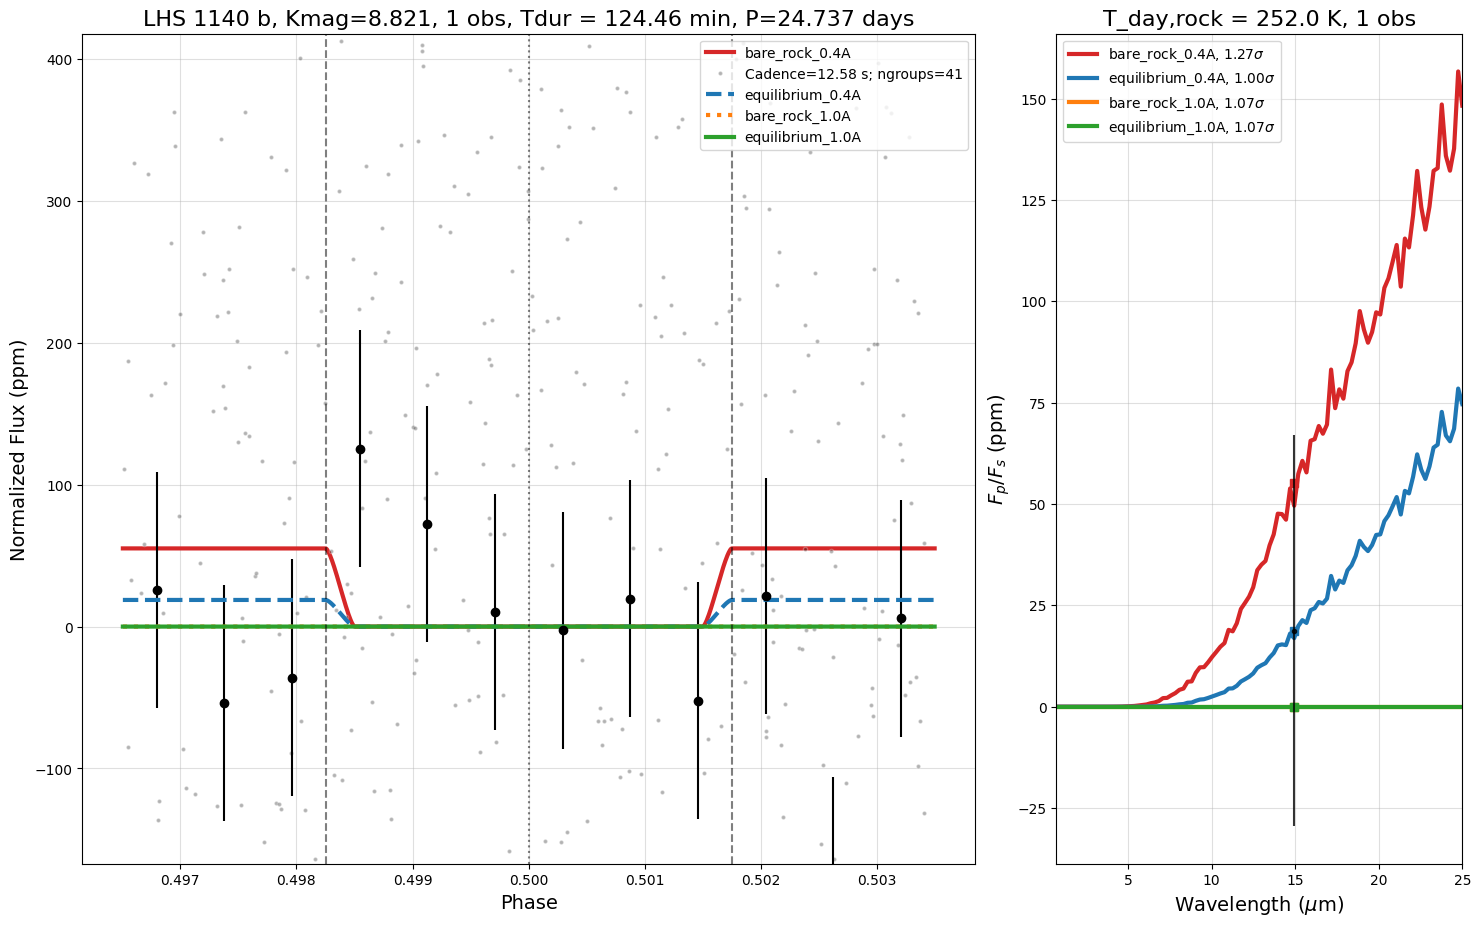

    chisq_red 1.1408923228664047
    sigma 1.068125611932613
    chisq_red 1.284969141837129
    sigma 1.133564793841599
    chisq_red 1.4308183180914096
    sigma 1.1961681813572163
    chisq_red 1.5775849339851113
    sigma 1.2560194799385624
    chisq_red 1.7249378443663708
    sigma 1.3133688911978996
    chisq_red 1.8727072178408697
    sigma 1.3684689319969618
    chisq_red 2.020792166770361
    sigma 1.4215456963356474
    chisq_red 2.1691269572773564
    sigma 1.4727956264456397
    chisq_red 2.317665930454614
    sigma 1.5223882325000464
    chisq_red 2.4663758423296915
    sigma 1.5704699431474944
    chisq_red 2.6152315963886843
    sigma 1.6171677700191456
    chisq_red 2.7642136951367138
    sigma 1.6625924621315713
    chisq_red 2.913306633239637
    sigma 1.7068411271233301
    chisq_red 3.0624978390321385
    sigma 1.7499993825805011
    chisq_red 3.2117769516594614
    sigma 1.7921431169578677
    chisq_red 3.3611353122749144
    sigma 1.8333399336388514
    chisq_red 

In [14]:
if run_one_target:
    starname = targ['hostname'].replace(' ', '')
    
    obs = MIRIImaging_Observation_Eclipse(targ,
                                          filter='f1500w',
                                          subarray='sub256',
                                          frac_fullwell=0.75,
                                          nobs=1,
                                          find_best_subarray=True
    )
    timing = obs.get_target_timing()
    print(obs.subarray)
    
    %matplotlib inline
    obs.model_target_obs(Albedos=Albedos, measurement_case=case_compare[0], display_figure=True)
    
    for nobs in np.arange(1, 100):
    
        yerr = obs.yerr / np.sqrt(nobs)
    
        np.random.seed(50)
        ndraws = 1000
        draw_eclipse_depth_measurement = np.random.normal(obs.models[f'{case_compare[0]}_{Albedos[0]}A']['fpfs_band'], yerr, ndraws)
        chisq = obs.calc_chi_sq(obs.models[f'{case_compare[-1]}_{Albedos[-1]}A']['fpfs_band'], draw_eclipse_depth_measurement, yerr) / ndraws # can do this trick since only 1 data point; this is also a hack because ndraws is default to 1000
        print('    chisq_red', chisq)
        sigma = obs.calc_significance(chisq, 1)
        print('    sigma', sigma)
    
        if sigma > sigma_thresh:
            break
    
    total_obs_time = (obs.tdur + obs.tdur*obs.tfrac + 30*u.min + 1*u.hr)*nobs
        
    print(sigma, nobs, total_obs_time.to(u.hr))


In [10]:
DDTargets.add_column(Column(name='subarray', data=[None]*len(DDTargets), dtype=object))
DDTargets.add_column(Column(name='ecl_depth', data=[None]*len(DDTargets), dtype=float, unit='ppm'))
DDTargets.add_column(Column(name='ecl_depth_err', data=[None]*len(DDTargets), dtype=float, unit='ppm'))
DDTargets.add_column(Column(name='nobs', data=np.ma.masked_all(len(DDTargets)), dtype=int))
DDTargets.add_column(Column(name='sigma', data=[None]*len(DDTargets), dtype=float))
DDTargets.add_column(Column(name='obshrs', data=[None]*len(DDTargets), dtype=float, unit='hr'))

In [13]:
tsettle_MIRI = 30*u.min
tcharge_JWST = 1*u.hr

for i in tqdm(range(len(DDTargets))):
    target = DDTargets[i]
    print(i, target['pl_name'])

    if not np.isnan(target['obshrs']):
        print('     already ran this one')
        print(f"    {target['subarray']}, {target['nobs']}, {target['obshrs']}")
        continue

    starname = targ['hostname'].replace(' ', '')
    
    obs = MIRIImaging_Observation_Eclipse(target,
                                          filter='f1500w',
                                          subarray='sub256',
                                          frac_fullwell=0.75,
                                          nobs=1,
                                          find_best_subarray=True,
                                          verbose=False
    )
    timing = obs.get_target_timing()
    #subarrays.append(obs.subarray)
    target['subarray'] = obs.subarray
    
    obs.model_target_obs(Albedos=[0.1, 0.4], measurement_case=case_compare[0], display_figure=False)

    target['ecl_depth'] = obs.models['bare_rock_0.1A']['fpfs_band'] * 1e6
    target['ecl_depth_err'] = obs.yerr * 1e6
    
    # as a rough estimate, I am compareing the bare rock case with A_B = 0.1 to the bare rock case for an A_B of 0.9. 
    # an A_B of 0.9 for a bare rock is basically impossible, so it's sort of mimicing a grey atmosphere
    # I am not using the "equilibrium" case becuase it is a assuming a lot about circulation, so can be much more different that realistic
    for nobs in np.arange(1, 100):
    
        yerr = obs.yerr / np.sqrt(nobs)
    
        np.random.seed(50)
        ndraws = 1000
        draw_eclipse_depth_measurement = np.random.normal(obs.models[f'{case_compare[0]}_{Albedos[0]}A']['fpfs_band'], yerr, ndraws)
        chisq = obs.calc_chi_sq(obs.models[f'equilibrium_0.4A']['fpfs_band'], draw_eclipse_depth_measurement, yerr) / ndraws # can do this trick since only 1 data point; this is also a hack because ndraws is default to 1000
        sigma = obs.calc_significance(chisq, 1)

        # consider a "sigma_limit" detection significant enough for this target
        if sigma > sigma_thresh:
            break
    
    #nobss.append(nobs)
    #sigmas.append(sigma)
    target['nobs'] = nobs
    target['sigma'] = sigma

    total_obs_time = (obs.tdur + obs.tdur*obs.tfrac + tsettle_MIRI + tcharge_JWST) * nobs
    #obshrs.append(total_obs_time.to(u.hr))

    target['obshrs'] = total_obs_time.to(u.hr).value

    print(f'    {obs.subarray}, {nobs}, {total_obs_time.to(u.hr).value}')

  0%|                                                                             | 0/79 [00:00<?, ?it/s]

0 LHS 1140 b


  1%|▊                                                                    | 1/79 [00:11<15:21, 11.81s/it]

    sub256, 99, 559.2163648038338
1 TRAPPIST-1 g


  1%|▊                                                                    | 1/79 [00:14<19:11, 14.76s/it]


KeyboardInterrupt: 

In [20]:
DDTargets['pl_name', 'subarray', 'ecl_depth_err', 'nobs', 'obshrs']

pl_name,subarray,ecl_depth_err,nobs,obshrs
,,ppm,,h
object,object,float64,int64,float64
LHS 1140 b,sub256,48.21332834263932,10,56.486501495336746
TRAPPIST-1 g,brightsky,142.78448568512775,46,173.40788762511625
LP 890-9 c,full,328.8534117460626,92,313.0378786774552
TOI-1452 b,brightsky,84.7421131975155,17,89.16064275436948
TOI-406.01,sub256,49.859959469049116,10,58.15210890209602
TRAPPIST-1 f,brightsky,148.82694971137997,35,125.62104736331953
K2-415 b,brightsky,141.43893162083563,34,122.07158860315775
TOI-198 b,sub256,37.89218412873669,30,142.84706014106212


In [21]:
ascii.write(DDTargets, outputpath+f'DDTargets_modified_{sigma_thresh}sigma.ecsv', format='ecsv', overwrite=True)

In [27]:
test = ascii.read(output+f'DDTargets_modified_{sigma_thresh}sigma.ecsv')
#test['pl_name','subarray', 'nobs', 'obshrs'][:25]
test['pl_name', 'ecl_depth_err'][:25]

pl_name,ecl_depth_err
,ppm
object,float64
LHS 1140 b,48.21332834263932
TRAPPIST-1 g,142.78448568512775
LP 890-9 c,328.8534117460626
TOI-1452 b,84.7421131975155
TOI-406.01,49.859959469049116
TRAPPIST-1 f,148.82694971137997
K2-415 b,141.43893162083563
TOI-198 b,37.89218412873669
